# Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

---

# Carga de datos

In [37]:
features = pd.read_pickle("../../features/auctions_train_ventana_1.pkl")
targets = pd.read_pickle("../../targets/targets_ventana_1_auctions.pkl")
train = features.merge(targets, left_index=True, right_index=True)

---

# Preparación del set de datos para XGBoost

In [38]:
X, y = train.iloc[:,:-1], train.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [39]:
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.7, learning_rate = 0.5,
                n_estimators = 100, n_jobs=6, max_depth=7, objective="reg:linear")

In [40]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=6, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [48]:
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

ValueError: feature_names mismatch: ['cantidad_apariciones', 'apariciones_en_hora_0', 'apariciones_en_hora_1', 'apariciones_en_hora_2', 'apariciones_en_hora_3', 'apariciones_en_hora_4', 'apariciones_en_hora_5', 'apariciones_en_hora_6', 'apariciones_en_hora_7', 'apariciones_en_hora_8', 'apariciones_en_hora_9', 'apariciones_en_hora_10', 'apariciones_en_hora_11', 'apariciones_en_hora_12', 'apariciones_en_hora_13', 'apariciones_en_hora_14', 'apariciones_en_hora_15', 'apariciones_en_hora_16', 'apariciones_en_hora_17', 'apariciones_en_hora_18', 'apariciones_en_hora_19', 'apariciones_en_hora_20', 'apariciones_en_hora_21', 'apariciones_en_hora_22', 'apariciones_en_hora_23', 'apariciones_en_dia_1', 'apariciones_en_dia_2', 'apariciones_en_dia_3', 'cantidad_so_registrados', 'so_media', 'tiempo_medio_entre_apariciones', 'tiempo_maximo_entre_apariciones', 'apariciones_en_source_0', 'apariciones_en_source_1', 'apariciones_en_source_2', 'apariciones_en_source_3', 'apariciones_en_source_4', 'apariciones_en_source_5', 'apariciones_en_source_6', 'apariciones_en_source_7', 'apariciones_en_source_8', 'apariciones_en_source_9', 'tiempo_ultima_aparicion_hasta_fin_ventana', 'tiempo_hora_frec_aparicion_subasta', 'tiempo_segunda_hora_frec_aparicion'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44']
expected apariciones_en_hora_0, cantidad_apariciones, apariciones_en_source_7, tiempo_ultima_aparicion_hasta_fin_ventana, apariciones_en_hora_4, apariciones_en_hora_20, apariciones_en_hora_12, apariciones_en_hora_2, apariciones_en_hora_9, apariciones_en_hora_10, apariciones_en_hora_11, apariciones_en_source_1, apariciones_en_hora_22, apariciones_en_hora_7, apariciones_en_source_4, apariciones_en_source_3, apariciones_en_hora_13, apariciones_en_dia_1, tiempo_segunda_hora_frec_aparicion, apariciones_en_hora_23, cantidad_so_registrados, apariciones_en_hora_3, apariciones_en_hora_5, tiempo_medio_entre_apariciones, tiempo_maximo_entre_apariciones, apariciones_en_hora_18, apariciones_en_source_6, apariciones_en_hora_16, apariciones_en_source_8, apariciones_en_hora_21, apariciones_en_source_0, apariciones_en_hora_17, apariciones_en_source_9, apariciones_en_dia_3, apariciones_en_hora_6, apariciones_en_hora_1, apariciones_en_hora_19, apariciones_en_hora_14, tiempo_hora_frec_aparicion_subasta, apariciones_en_hora_15, apariciones_en_dia_2, apariciones_en_hora_8, so_media, apariciones_en_source_5, apariciones_en_source_2 in input data
training data did not have the following fields: f36, f27, f37, f34, f7, f17, f21, f35, f43, f18, f2, f24, f16, f10, f8, f32, f14, f5, f20, f15, f28, f40, f42, f0, f6, f30, f33, f4, f25, f22, f9, f23, f26, f11, f38, f39, f41, f12, f3, f19, f29, f1, f13, f31, f44

---

# Pruebas

## SGD

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data

In [43]:
from sklearn.linear_model import SGDRegressor

In [51]:
rg=SGDRegressor(loss="log")

ValueError: The loss losg is not supported. 

In [45]:
rg.fit(X_train, y_train)

/opt/anaconda/3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [49]:
preds = rg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 92632.606660


---

In [20]:
features_auctions = pd.read_pickle("../../features/auctions_train_ventana_1.pkl")
features_clicks = pd.read_pickle("../../features/clicks_train_ventana_1.pkl")

In [21]:
features_combinados_imputados = features_auctions.merge(features_clicks, right_index=True, left_index=True, suffixes=('_auctions', '_clicks')).fillna(0)

In [17]:
len(features_combinados_imputados)

9144

In [27]:
#features_auctions = pd.read_pickle("../../features/auctions_train_ventana_3.pkl")
targets = pd.read_pickle("../../targets/targets_ventana_1_auctions.pkl")
train = features_combinados_imputados.merge(targets, left_index=True, right_index=True)

X, y = train.iloc[:,:-1], train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':6,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.1}


num_round = 5000
stopping = 20
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)
# make prediction
#preds = bst.predict(dtest)
#Stopping. Best iteration:
#[360]	train-rmse:67651	test-rmse:69665.3a

[0]	train-rmse:112057	test-rmse:113310
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:106220	test-rmse:107639
[2]	train-rmse:100664	test-rmse:102448
[3]	train-rmse:95998.8	test-rmse:98074.7
[4]	train-rmse:91925.2	test-rmse:94382.7
[5]	train-rmse:88440.8	test-rmse:91209.7
[6]	train-rmse:85339	test-rmse:88431.3
[7]	train-rmse:82728.4	test-rmse:86177.8
[8]	train-rmse:80499.4	test-rmse:84284.5
[9]	train-rmse:78494	test-rmse:82702.5
[10]	train-rmse:76818.4	test-rmse:81374.8
[11]	train-rmse:75350.1	test-rmse:80181.9
[12]	train-rmse:74086.8	test-rmse:79207
[13]	train-rmse:72958.6	test-rmse:78540.7
[14]	train-rmse:71949.1	test-rmse:77874.5
[15]	train-rmse:71099.3	test-rmse:77349.9
[16]	train-rmse:70341.1	test-rmse:76963.5
[17]	train-rmse:69703.8	test-rmse:76625.2
[18]	train-rmse:69078.7	test-rmse:76353
[19]	train-rmse:68561.6	test-rmse:76070.3
[20]	train-rmse:68129.1	test-rmse:75840.2

---

# Prueba con 1 modelo y todos los datos

In [27]:
f1 = pd.read_pickle("../../features/auctions_train_ventana_3.pkl")
f2 = pd.read_pickle("../../features/clicks_train_ventana_3.pkl")
f3 = pd.read_pickle("../../features/events_train_ventana_3.pkl")

In [28]:
magifeatures = f2.dropna().merge(f1, left_index=True, right_index=True).merge(f3, left_index=True, right_index=True)
magitargets = pd.read_pickle("../../targets/targets_ventana_3_auctions.pkl")
magitrain = magifeatures.merge(magitargets, left_index=True, right_index=True)

RMSE: 76447.4360291326


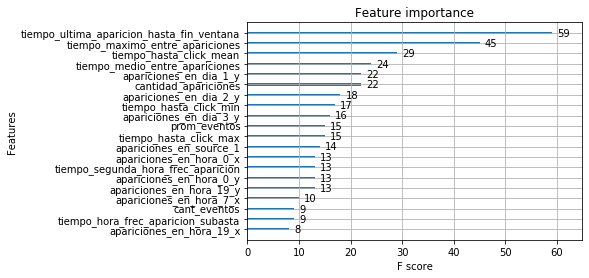

In [30]:
from xgboost import XGBRegressor, plot_importance
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from math import sqrt

X, y = magitrain.iloc[:,:-1], magitrain.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=4)

# fit model on all training data
model = XGBRegressor()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print("RMSE: {}".format(sqrt(rmse)))

plot_importance(model, max_num_features=20)
pyplot.show()

In [36]:
X, y = magitrain.iloc[:,:-1], magitrain.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':6,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 1,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.01}


num_round = 5000
stopping = 20
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)

[0]	train-rmse:118467	test-rmse:120787
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:117692	test-rmse:120171
[2]	train-rmse:116919	test-rmse:119552
[3]	train-rmse:116163	test-rmse:118946
[4]	train-rmse:115412	test-rmse:118361
[5]	train-rmse:114668	test-rmse:117784
[6]	train-rmse:113940	test-rmse:117199
[7]	train-rmse:113214	test-rmse:116654
[8]	train-rmse:112502	test-rmse:116101
[9]	train-rmse:111787	test-rmse:115520
[10]	train-rmse:111088	test-rmse:115002
[11]	train-rmse:110399	test-rmse:114466
[12]	train-rmse:109715	test-rmse:113950
[13]	train-rmse:109038	test-rmse:113442
[14]	train-rmse:108371	test-rmse:112926
[15]	train-rmse:107706	test-rmse:112419
[16]	train-rmse:107053	test-rmse:111935
[17]	train-rmse:106417	test-rmse:111428
[18]	train-rmse:105753	test-rmse:110907
[19]	train-rmse:105119	test-rmse:110442
[20]	train-rmse:104508	test-rmse:109932
[21]	train-rmse:103874	test

In [32]:
features = pd.read_pickle("../../features/auctions_train_ventana_1.pkl")
features_clicks = pd.read_pickle("../../features/clicks_train_ventana_1.pkl")
features.merge(features_clicks, right_index=True, left_index=True, how="left", suffixes=('_auctions', '_clicks'))
targets = pd.read_pickle("../../targets/targets_ventana_1_auctions.pkl")
train = features.merge(targets, left_index=True, right_index=True)

features = pd.read_pickle("../../features/auctions_train_ventana_2.pkl")
features_clicks = pd.read_pickle("../../features/clicks_train_ventana_2.pkl")
features.merge(features_clicks, right_index=True, left_index=True,how="left", suffixes=('_auctions', '_clicks'))
targets = pd.read_pickle("../../targets/targets_ventana_2_auctions.pkl")
train = train.append(features.merge(targets, left_index=True, right_index=True))

features = pd.read_pickle("../../features/auctions_train_ventana_3.pkl")
features_clicks = pd.read_pickle("../../features/clicks_train_ventana_3.pkl")
features.merge(features_clicks, right_index=True, left_index=True,how="left", suffixes=('_auctions', '_clicks'))
targets = pd.read_pickle("../../targets/targets_ventana_3_auctions.pkl")
train = train.append(features.merge(targets, left_index=True, right_index=True))

features = pd.read_pickle("../../features/auctions_train_ventana_4.pkl")
features_clicks = pd.read_pickle("../../features/clicks_train_ventana_4.pkl")
features.merge(features_clicks, right_index=True, left_index=True,how="left", suffixes=('_auctions', '_clicks'))
targets = pd.read_pickle("../../targets/targets_ventana_4_auctions.pkl")
train = train.append(features.merge(targets, left_index=True, right_index=True))

In [13]:
len(train)

1286041

In [35]:
X, y = train.iloc[:,:-1], train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':6,
         'eta':0.3,
         'n_jobs' : 6,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.1}


num_round = 5000
stopping = 20
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)
#Stopping. Best iteration:
#[491]	train-rmse:87591.8	test-rmse:88927.6

[0]	train-rmse:148651	test-rmse:148586
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:139425	test-rmse:139387
[2]	train-rmse:131702	test-rmse:131681
[3]	train-rmse:124879	test-rmse:124884
[4]	train-rmse:119066	test-rmse:119095
[5]	train-rmse:114208	test-rmse:114256


KeyboardInterrupt: 